<a href="https://colab.research.google.com/github/nadnik13/sparse_grid/blob/main/AlgorithimClusteringOnPoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import sys
from math import  factorial as fac
from sklearn import datasets,metrics
from itertools import cycle, islice

In [2]:
# demo
np.random.seed(1)
n_samples=1000
X_circles,y_circles=datasets.make_circles(n_samples,factor=.5,noise=.05)
# y_circles=y_circles*2-1
X_moons,y_moons=datasets.make_moons(n_samples, noise=0.05)
X_blobs,y_blobs=datasets.make_blobs(n_samples, centers = 2)
# X_rand, y_rand = np.random.rand(n_samples, 2), None

### Визуализация данных

In [3]:
# для классов 0,1
def makePlots(X_points,y_points):
  plt.figure(figsize=(18, 6))

  colors=np.array(["r","b", "y"])
  plt.subplot(131)
  X,y = X_points[0],y_points[0]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])

  plt.subplot(132)
  X,y = X_points[1],y_points[1]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
  plt.subplot(133)

  X,y = X_points[2],y_points[2]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])

  plt.show()

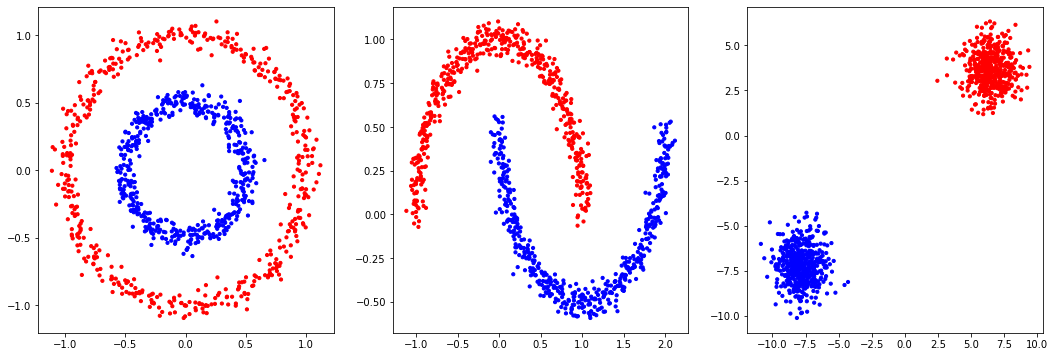

In [4]:
makePlots([X_circles, X_moons, X_blobs], [y_circles,y_moons,y_blobs])

### Классификация K-Means

In [5]:
from sklearn.cluster import KMeans

def kelner(data, n_clusters=2):
  kmeans = KMeans(n_clusters)
  kmeans.fit(data)
  y_kmeans = kmeans.predict(data)
  return y_kmeans

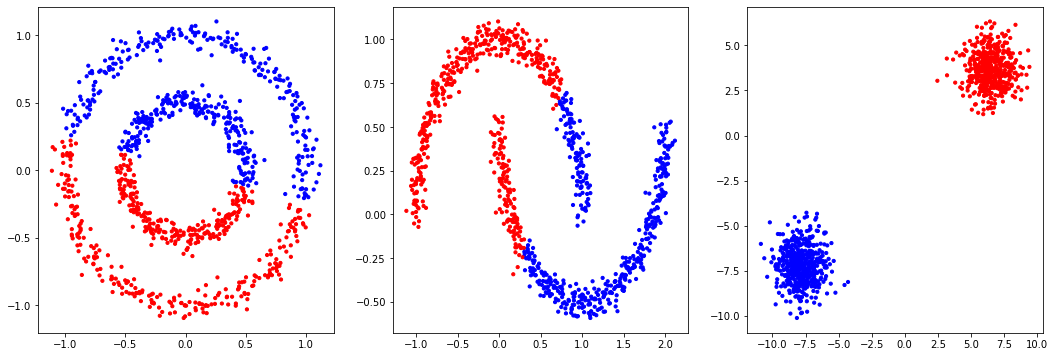

In [6]:
makePlots([X_circles, X_moons, X_blobs], [kelner(X_circles),kelner(X_moons),kelner(X_blobs)])

### Классификация с использованием спектральной кластеризации

In [7]:
from sklearn.metrics.pairwise import check_pairwise_arrays,euclidean_distances

def simmularity(X, Y, sigma=0.4, r = 5):
    """
    Compute the rbf (gaussian) kernel between X and Y::
        K(x, y) = exp(-sigma ||x-y||^2)

    -------
    kernel_matrix : ndarray of shape (n_samples_X, n_samples_Y)
    """
    X, Y = check_pairwise_arrays(X, Y)
    K = euclidean_distances(X, Y, squared=True) 

    K[np.where(K >= r)] = 0.
    K *= -sigma
    np.exp(K, K)  # exponentiate K in-place
    K[np.where(K == 1.)] = 0.
    return K

In [8]:
def getV(X):
  S = simmularity(X,X)

  D = np.diag(S.sum(axis=1))
  L = D-S
  eigenvalues, eigenvectors = np.linalg.eig(L)
  order = np.argsort(eigenvalues)
  eigenvalues = eigenvalues[order]

  v_0 = eigenvectors[:, order[0]]
  v_1 = eigenvectors[:, order[1]]
  v_2 = eigenvectors[:, order[2]]
  v = eigenvectors[:, order[1:2]]
  return v

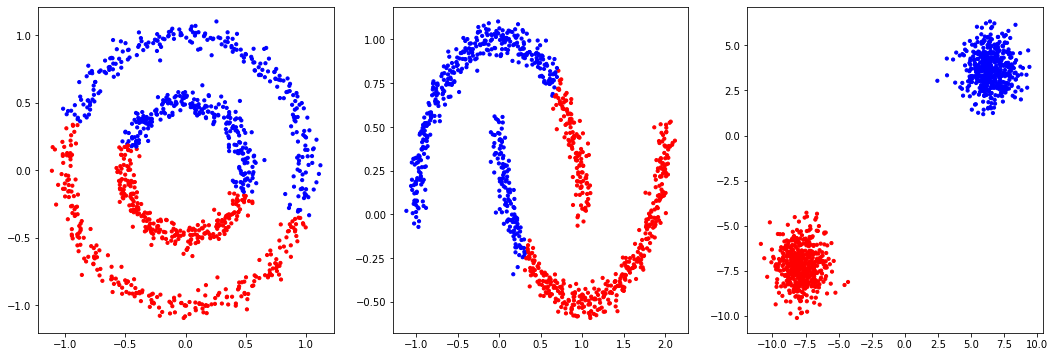

In [9]:
makePlots([X_circles, X_moons, X_blobs], [kelner(getV(X_circles)),kelner(getV(X_moons)),kelner(getV(X_blobs))])

### Классификация с использованием спектральной кластеризации и разреженной сетки

In [10]:
n = 5
n_points = n_samples

def fun(ix):
  iy = int(ix * (len(points_labels)-1))
  # print(iy)
  return points_labels[iy]

def xli(l, i):
    return i * (2 ** (-l))

def add_a(e):
    e['a'] = fun(xli(e['l'], e['i']))
#     print(f"add_a: i={e['i']} l={e['l']} e['i'] // 4={e['i'] % 4} e['i'] // 3={e['i'] % 3}")
    if e['l'] == 1:
        e['a'] += -0.5 * (fun(xli(e['l'], e['i']- 1)) + fun(xli(e['l'], e['i'] + 1)))
    elif (e['i'] % 4 == 1 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun(xli(e['l'], e['i'] - 1)) + 6*fun(xli(e['l'], e['i'] + 1)) - fun(xli(e['l'], e['i'] + 3)))
    elif (e['i'] % 4 == 3 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun(xli(e['l'], e['i'] + 1)) + 6*fun(xli(e['l'], e['i'] - 1)) - fun(xli(e['l'], e['i'] - 3)))
#     print(f"a = {e['a']}")
    # print(f"e['l']={e['l']} e['i']={e['i']} a_recursion={e['a']}")
    return e

def build_grid():
  grid = [add_a({'l': 1, 'i': 1})]

  for e in grid:
      if e['l'] == n or abs(e['a']) < 1e-3:
          continue
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] - 1}))
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] + 1}))

  grid.append(add_a({'l': 0, 'i': 0}))
  grid.append(add_a({'l': 0, 'i': 1}))
  return grid.copy()


def phi_1(x):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0

def phi_2(x):
    if -1 <= x <= 1:
        return - (x-1)*(x+1)
    return 0

def phi_li(l, i, x):
    if l == 0:
        return phi_1(x * 2 ** l - i)
    else:
        return phi_2(x * 2 ** l - i)

def eval(x):
    r = 0
    b = []
    for e in grid:
      phi_lix = phi_li(e['l'], e['i'], x)
      r += e['a'] * phi_lix
      b.append(phi_lix)
    return b.copy()

In [11]:
from scipy.linalg import eigh

In [12]:
points_labels = y_blobs
grid = np.array(build_grid())
grid.shape

(33,)

In [13]:
def get_b(n_points, grid):
  b = []
  for i in range(n_points):
    x = i * 1./(n_points-1)
    b.append(eval(x))
  return b.copy()


#### Для blob dataset

In [14]:
X = X_blobs
y = y_blobs
y=y*2-1

In [15]:
np.unique(y)

array([-1,  1])

In [16]:
S = simmularity(X,X)

D = np.diag(S.sum(axis=1))
L = D-S
points_labels = y
grid = build_grid()
print(grid)
print(n_points)
b = get_b(n_points, grid)
B = np.array(b).reshape((n_points, len(grid)))
L_s = B.T.dot(L).dot(B)
D_s = B.T.dot(D).dot(B)
eigvals, eigvecs = eigh(L_s, D_s, eigvals_only=False)

order = np.argsort(eigvals)
eigvals = eigvals[order]

v_0 = eigvecs[:, order[0]]
v_1 = eigvecs[:, order[1]]
v_2 = eigvecs[:, order[2]]
v = eigvecs[:, order[1:2]]


[{'l': 1, 'i': 1, 'a': 1.0}, {'l': 2, 'i': 1, 'a': -1.25}, {'l': 2, 'i': 3, 'a': -2.25}, {'l': 3, 'i': 1, 'a': 0.25}, {'l': 3, 'i': 3, 'a': 1.25}, {'l': 3, 'i': 5, 'a': -0.5}, {'l': 3, 'i': 7, 'a': 1.5}, {'l': 4, 'i': 1, 'a': 2.0}, {'l': 4, 'i': 3, 'a': 2.0}, {'l': 4, 'i': 5, 'a': 0.75}, {'l': 4, 'i': 7, 'a': -2.25}, {'l': 4, 'i': 9, 'a': -0.75}, {'l': 4, 'i': 11, 'a': 2.25}, {'l': 4, 'i': 13, 'a': -1.25}, {'l': 4, 'i': 15, 'a': -2.25}, {'l': 5, 'i': 1, 'a': -1.5}, {'l': 5, 'i': 3, 'a': 0.5}, {'l': 5, 'i': 5, 'a': 0.5}, {'l': 5, 'i': 7, 'a': 0.5}, {'l': 5, 'i': 9, 'a': 0.75}, {'l': 5, 'i': 11, 'a': -2.25}, {'l': 5, 'i': 13, 'a': 1.5}, {'l': 5, 'i': 15, 'a': 1.5}, {'l': 5, 'i': 17, 'a': 1.25}, {'l': 5, 'i': 19, 'a': 2.25}, {'l': 5, 'i': 21, 'a': 0.5}, {'l': 5, 'i': 23, 'a': -1.5}, {'l': 5, 'i': 25, 'a': 0.25}, {'l': 5, 'i': 27, 'a': -0.75}, {'l': 5, 'i': 29, 'a': -0.5}, {'l': 5, 'i': 31, 'a': 1.5}, {'l': 0, 'i': 0, 'a': -1}, {'l': 0, 'i': 1, 'a': 1}]
1000


In [17]:
# для классов -1,1
def makePlots1(X_points,y_points):
  plt.figure(figsize=(18, 6))

  colors=np.array(["r","b"])
  plt.subplot(131)
  X,y = X_points[0],y_points[0]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[((1+y)/2).astype(int)])

  plt.subplot(132)
  X,y = X_points[1],y_points[1]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[((1+y)/2).astype(int)])
  plt.subplot(133)

  X,y = X_points[2],y_points[2]
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[((1+y)/2).astype(int)])

  plt.show()

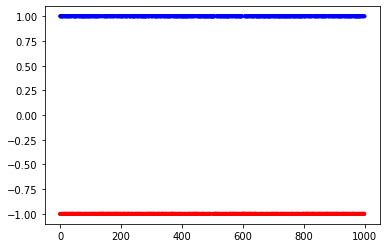

In [23]:
  colors=np.array(["r","b"])
  plt.scatter(range(0, n_points), y, s=10, color=colors[((1+y)/2).astype(int)])

In [20]:
v_blobs = v

In [21]:
points = [int(xli(e['l'], e['i']) * (len(points_labels)-1)) for e in grid]
points_y = [fun(xli(e['l'], e['i'])) for e in grid]
coord = X[points]
coord.shape

(33, 2)

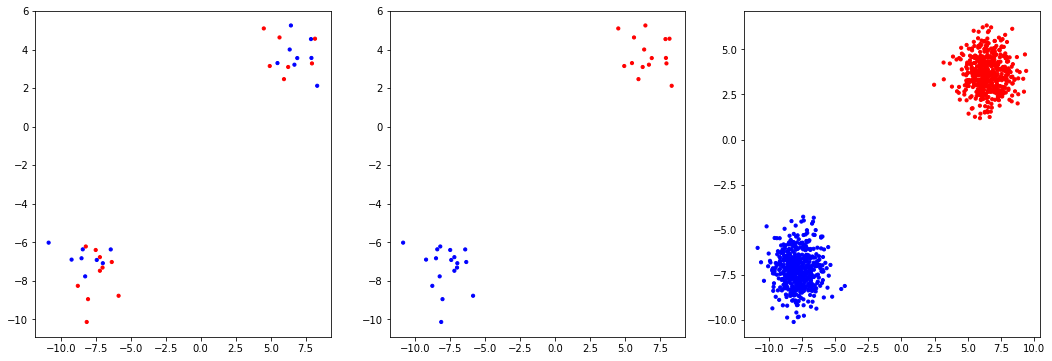

In [22]:
makePlots1([coord, coord, X_blobs], [np.array(kelner(v_blobs)),np.array(points_y),np.array(kelner(getV(X_blobs)))])